In [372]:
# ---------------------------------------------------------------------------------------
# Load packages
# ---------------------------------------------------------------------------------------
import os
import warnings
import pandas as pd
import numpy as np
from itertools import chain
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from scipy.stats import norm, mstats
from datetime import datetime, timedelta, date
import calendar
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [12,5]

import random 
random.seed(123)

warnings.filterwarnings("ignore") 

In [373]:
# import custome functions
import customFunctions as custFun

In [374]:
atmId = '5463'
user = 'GauravJ'
workingDir = "/home/biphsgadm/GauravJ/PythonCode/TrainingData/"

file_path = workingDir + 'output/' + user + '/'
     
custFun.ensure_dir(file_path)

In [375]:
# ---------------------------------------------------------------------------------------
# Set date ranges for training, prediction and validation
# ---------------------------------------------------------------------------------------
dtFormat = "%Y-%m-%d"

predDelta = 7
monthsOffset = 24

# will be used for Forecasting 
predStartDate = pd.to_datetime('2016-12-10')
predEndDate =  predStartDate + pd.DateOffset(months=0, days=predDelta-1)
# will be used for Training 
trainStartDate = predStartDate + pd.DateOffset(months=-monthsOffset, days=0)
trainEndDate = predStartDate + pd.DateOffset(months=0, days=-1)
# will be used for Validation 
valStartDate = predStartDate + pd.DateOffset(months=-1, days=0)
valEndDate = trainEndDate

In [376]:
print ("Old date is ", trainStartDate)
if (trainStartDate < pd.to_datetime('2015-01-01')):
    trainStartDate = pd.to_datetime('2015-01-01')
print ("New date is ", trainStartDate)

Old date is  2014-12-10 00:00:00
New date is  2015-01-01 00:00:00


In [377]:
#------------------------------------------------------------------------------------------------------
# Load SAS data set
#------------------------------------------------------------------------------------------------------
#
# SELECT ATMCAM_ID, 
#    FROM_UNIXTIME(UNIX_TIMESTAMP(TXN_DTTM, 'yyyy-MM-dd HH:mm:ss'), 'yyyy-MM-dd HH:mm:ss') as TXN_DTTM, 
#    FROM_UNIXTIME(UNIX_TIMESTAMP(RUN_DTTM,'yyyy-MM-dd'), 'yyyy-MM-dd') as RUN_DTTM, 
#    PREDICT, 
#    PREDICT_SYSTEM
# FROM BIPHSG_EDLDB.OUTFOR_AMRS
# WHERE ATMCAM_ID = 8178
# AND SCHED_DT >= FROM_UNIXTIME(UNIX_TIMESTAMP('2015-12-01','yyyy-MM-dd'), 'yyyy-MM-dd');
#
#------------------------------------------------------------------------------------------------------
dfSAS= pd.read_csv(workingDir + "SAS/ATM_" + atmId + "_SAS_ALL.csv")
dfSAS.columns = ['atmcam_id','txn_dttm','run_dttm','predict','predict_system']

dfSAS.run_dttm = pd.to_datetime(dfSAS.run_dttm)
dfSAS.txn_dttm = pd.to_datetime(dfSAS.txn_dttm)

In [378]:
# subset data between prediction start and end
dfSAS_sub = dfSAS.loc[(dfSAS.run_dttm == predStartDate)]

# select data between txn dttm start and end
dfSAS_sub.index = pd.to_datetime(dfSAS_sub['txn_dttm'].values)
dfSAS_sub['tranDate'] = pd.to_datetime(pd.to_datetime(dfSAS_sub.index).date)

In [379]:
# Aggregate SAS data
dfSAS_agg = dfSAS_sub.groupby(['tranDate'])[["predict", "predict_system"]].sum()
dfSAS_agg.index = pd.to_datetime(dfSAS_agg.index)

In [380]:
predStartDateTime = pd.to_datetime(predStartDate.strftime("%Y-%m-%d 00:00:00"))
predEndDateTime = pd.to_datetime(predEndDate.strftime("%Y-%m-%d 23:00:00"))

dfSAS_agg = dfSAS_agg[predStartDate:predEndDate]

dfSAS_hr = dfSAS_sub.loc[(dfSAS_sub.tranDate >= predStartDateTime) & (dfSAS_sub.tranDate <= predEndDateTime)].sort_index()

In [381]:
# ---------------------------------------------------------------------------------------
# Load ATM data set
# ---------------------------------------------------------------------------------------
df= pd.read_csv(workingDir + "ATM/ATM_" + atmId + "_ALL.csv")

In [382]:
df.columns = ['trandate','amt']
df['trandate'] = pd.to_datetime(df['trandate'])

In [383]:
# ---------------------------------------------------------------------------------------
# Indexing with Time-series Data
# ---------------------------------------------------------------------------------------
df_hr = df.copy()

#Set data['date'] as the index and delete the column
df_hr.index = df_hr['trandate'].values
del df_hr['trandate']

#df_hr.sort_index().head()

In [384]:
df_agg = df_hr.groupby(df_hr.index.date).sum()
df_agg.index = pd.to_datetime(df_agg.index)

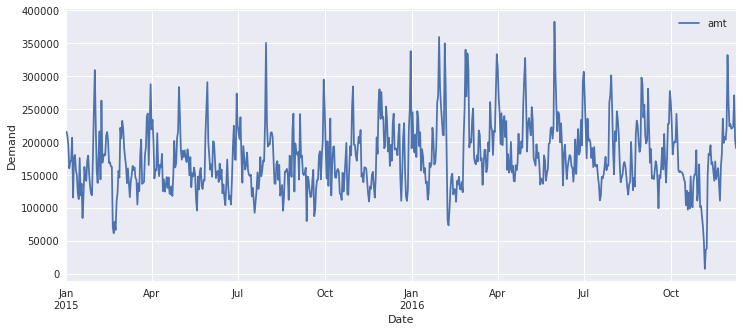

In [385]:
ax =  df_agg[trainStartDate:trainEndDate].plot()
ax.set_xlabel('Date')
ax.set_ylabel('Demand')

plt.legend()
sns.despine()

In [386]:
#train = df_agg[trainStartDate:trainEndDate].rolling(window = 3, min_periods = 1).mean().sort_index()
train = df_agg[trainStartDate:trainEndDate].sort_index()

In [387]:
#imputation of missing dates
train =  train.resample('D')
train = train.interpolate(method='linear')

In [388]:
train.amt = train.amt.mask(train.amt == 0, train.amt.median())
train.amt = custFun.get_median_filtered(train.amt, 3)
train.amt = custFun.percentile_based_outlier(train.amt, 95)

In [389]:
# Impute Missing Values in Time-series Data
#print ("No. of Missing values", y.isnull().sum())

# we can fill in missing values with the closest non-null value in our time series
train = train.fillna(train.median())

# With missing values filled in, we can once again check to see whether any null values 
# exist to make sure that our operation worked:
#print ("No. of Missing values post imputation", y.isnull().sum())

In [390]:
decomposition = custFun.seasonal_decompose(train, 'amt')

observed = decomposition.observed
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

d = custFun.set_stationarity_val(observed)
D = custFun.set_stationarity_val(seasonal)

Time Series is stationary  0
Time Series is  nonstationary  1


In [391]:
print ("Start hyper parameter tunnig.. ", datetime.now().strftime('%d-%m-%Y %H:%M:%S'))

gridResult = custFun.easy_parallize_SARIMAX(train, 10, [5,d,5], [0,0,0,7])

print ("End hyper parameter tunnig.. ", datetime.now().strftime('%d-%m-%Y %H:%M:%S'))

Start hyper parameter tunnig..  22-09-2017 20:08:58
End hyper parameter tunnig..  22-09-2017 20:09:25


In [392]:
# find min value for AIC 
parameter = gridResult.sort_values(['aic'], ascending=True)
print (parameter.head(5))

p, d, q = parameter.iloc[0,2]
P, D, Q, S = parameter.iloc[0,3]

             aic           bic      order       s_order
35  16456.126929  16506.329340  (5, 0, 5)  (0, 0, 0, 7)
23  16459.565441  16500.640141  (3, 0, 5)  (0, 0, 0, 7)
29  16462.400142  16508.038697  (4, 0, 5)  (0, 0, 0, 7)
11  16462.876355  16494.823343  (1, 0, 5)  (0, 0, 0, 7)
17  16463.281131  16499.791976  (2, 0, 5)  (0, 0, 0, 7)


In [393]:
# ---------------------------------------------------------------------------------------
# Fitting an ARIMA Time Series Model
# The (p,d,q) order of the model  4,0,4 / 5,0,5,7
# ---------------------------------------------------------------------------------------
mod = sm.tsa.statespace.SARIMAX(train.sort_index(),
                                order=(p, d, q),
                                seasonal_order=(P, D, Q, S),
                                #order=(5,0,5),
                                #seasonal_order=(0,0,0,7),
                                enforce_stationarity = False,
                                enforce_invertibility = False
                                )
results = mod.fit(disp=False)
# print (results.aic)
# print (results.summary())

In [394]:
# Get forecast n steps ahead in future
pred_uc = results.get_forecast(steps=predDelta)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

In [395]:
# Extract the predicted values of our time series
y_hat = round(pred_uc.predicted_mean,0).to_frame().reset_index()
y_hat.columns = ['trandate','amt']

# Convert data['tran_date'] from string to datetime
y_hat['trandate'] = pd.to_datetime(y_hat['trandate'])

#Set data['date'] as the index and delete the column
y_hat.index = y_hat['trandate']
del y_hat['trandate']

In [396]:
forecast = pd.concat([y_hat, pred_ci], axis = 1)
forecast.columns = ['y_hat', 'lowerci', 'upperci']

# set negative forecast to $1
forecast['y_hat'] = forecast.apply(lambda df: custFun.adjustNegativeForecast(df.y_hat), axis=1) 
#forecast

In [397]:
spDaystart = trainStartDate
spDayend =  predEndDate + pd.DateOffset(months=0, days=30)

publicHoliday = custFun.read_one(workingDir + "SGPublicHoliday.csv")

publicHoliday['date'] = pd.to_datetime(publicHoliday['date'])
publicHoliday.index = publicHoliday['date']
publicHoliday = publicHoliday[spDaystart:spDayend]

publicHoliday.head()

,date,lower_window,upper_window,holidaycode,type
date,,,,,
2015-01-01,2015-01-01,0,0,NewYearDay,OTH
2015-02-19,2015-02-19,4,1,ChineseNewYear,CNY
2015-02-20,2015-02-20,4,1,ChineseNewYear,CNY
2015-04-03,2015-04-03,0,0,GoodFriday,OTH
2015-05-01,2015-05-01,0,0,LabourDay,OTH


In [398]:
spDaytable = pd.DataFrame(index = pd.to_datetime(pd.date_range(start = spDaystart, end = spDayend, freq = 'D')))
spDaytable = pd.merge(spDaytable, publicHoliday, left_index=True, right_index=True, how='left')

spDaytable['ph'] = spDaytable.apply(lambda df: custFun.setPH(df.lower_window, df.upper_window), axis=1)

In [399]:
preHolidayList = []

for index, row in publicHoliday.iterrows():
    if (row.lower_window != 0 ):
        preHolidayList.append(custFun.createPrePostHolidayList(row.date, row.lower_window, True))
    
preHolidayList = pd.DataFrame(list(set(chain.from_iterable(preHolidayList))))

preHolidayList.columns = ['date']
preHolidayList['preholiday'] = 'Y'

preHolidayList.index = preHolidayList['date']
del preHolidayList['date']

spDaytable = pd.merge(spDaytable, preHolidayList, left_index=True, right_index=True, how='left')
spDaytable[['preholiday']] = spDaytable[['preholiday']].fillna('N')

In [400]:
postHolidayList = []

for index, row in publicHoliday.iterrows():
    if (row.upper_window != 0 ):
        postHolidayList.append(custFun.createPrePostHolidayList(row.date, row.upper_window, False))
    
postHolidayList =  pd.DataFrame(list(set(chain.from_iterable(postHolidayList))))

postHolidayList.columns = ['date']
postHolidayList['postholiday'] = 'Y'

postHolidayList.index = postHolidayList['date']
del postHolidayList['date']

spDaytable = pd.merge(spDaytable, postHolidayList, left_index=True, right_index=True, how='left')
spDaytable[['postholiday']] = spDaytable[['postholiday']].fillna('N')

In [401]:
# set preholiday to N where ph is Y
spDaytable.loc[spDaytable['ph'] == 'Y', 'preholiday'] = 'N'
spDaytable.loc[spDaytable['ph'] == 'Y', 'postholiday'] = 'N'

In [402]:
# set flags for pre holiday dates
for index, row in publicHoliday.iterrows():
    for i in range(1, row.lower_window+1):
        x = i
        dtIndex = pd.to_datetime(index - pd.DateOffset(months=0, days=x)).strftime("%Y-%m-%d")
        if (dtIndex in spDaytable.index):
            if (spDaytable[dtIndex:dtIndex].ph.values == 'N'):
                spDaytable.set_value(dtIndex, 'holidayoffset', x)
                spDaytable.set_value(dtIndex, 'holidayevecode', row.type)
            else:
                break
    for i in range(1, row.upper_window+1):
        x = i
        dtIndex = pd.to_datetime(index + pd.DateOffset(months=0, days=x)).strftime("%Y-%m-%d")
        if (dtIndex in spDaytable.index):
            if (spDaytable[dtIndex:dtIndex].ph.values == 'N'):
                spDaytable.set_value(dtIndex, 'holidayoffset', x)
                spDaytable.set_value(dtIndex, 'holidayevecode', row.type)
            else:
                break

In [403]:
spDaytable['day'] = pd.to_datetime(spDaytable.index).day
spDaytable['month'] = pd.to_datetime(spDaytable.index).month
spDaytable['year'] = pd.to_datetime(spDaytable.index).year

spDaytable['quarter'] = spDaytable.apply(lambda df: custFun.get_quarter(df.month), axis=1)

spDaytable['weekofmonth'] = spDaytable.apply(lambda df: custFun.get_week_of_month(df.year, df.month, df.day), axis=1)
spDaytable['weekday'] = pd.to_datetime(spDaytable.index).weekday
spDaytable['weekday'] = spDaytable.apply(lambda df: custFun.weekGroups(df.weekday), axis=1)

spDaytable['numdays'] = spDaytable.apply(lambda df: calendar.monthrange(df.year, df.month)[1], axis=1)
spDaytable = spDaytable.drop(['date', 'lower_window', 'upper_window', 'year', 'numdays'], axis=1)

# fill null values with 0 or N
spDaytable[['holidaycode','type','ph','preholiday','postholiday','holidayevecode']] = spDaytable[['holidaycode','type','ph','preholiday','postholiday','holidayevecode']].fillna(value='N')
spDaytable[['holidayoffset']] = spDaytable[['holidayoffset']].fillna(value=0)

In [404]:
dfProfile = pd.merge(df_agg[trainStartDate:trainEndDate], spDaytable, left_index=True, right_index=True, how='left')

In [405]:
forecast = pd.merge(forecast, spDaytable, left_index=True, right_index=True, how='left')
forecast = forecast.fillna('N')
forecast.head()

,y_hat,lowerci,upperci,holidaycode,type,ph,preholiday,postholiday,holidayoffset,holidayevecode,day,month,quarter,weekofmonth,weekday
trandate,,,,,,,,,,,,,,,
2016-12-10,199687.0,143206.304605,256167.189349,N,N,N,N,N,0.0,N,10,12,1,2,5
2016-12-11,205255.0,140967.910228,269543.086815,N,N,N,N,N,0.0,N,11,12,1,3,6
2016-12-12,198282.0,130114.864131,266449.786157,N,N,N,N,N,0.0,N,12,12,1,3,0
2016-12-13,193892.0,122298.302428,265485.135727,N,N,N,N,N,0.0,N,13,12,1,3,1
2016-12-14,192751.0,119009.338148,266492.308674,N,N,N,N,N,0.0,N,14,12,1,3,1


In [406]:
# get max and Avg profile amt 
for index, row in forecast.iterrows():
    indx = pd.to_datetime(index).strftime("%Y-%m-%d")
    
    # For holidays
    if ((row['ph'] == 'Y')):
        tempDf = dfProfile.loc[(dfProfile['type'] == row['type'])].index.strftime('%Y-%m-%d')
        tempList = custFun.getMaxAndAvgAmt(tempDf, dfProfile)
        forecast.set_value(index, 'maxprofileamt1', tempList[0])
        forecast.set_value(index, 'avgprofileamt1', tempList[1])
    else:
        forecast.set_value(index, 'maxprofileamt1', 0)
        forecast.set_value(index, 'avgprofileamt1', 0)
    
    # for day and weekday
    tempDf = dfProfile.loc[(dfProfile['type'] == 'N') & (dfProfile['holidayevecode'] == 'N') & (dfProfile['day'] == row['day']) & (dfProfile['weekday'] == row['weekday'])].index.strftime('%Y-%m-%d')
    if (len(tempDf)>0):
        tempList = custFun.getMaxAndAvgAmt(tempDf, dfProfile)
        forecast.set_value(index, 'maxprofileamt2', tempList[0])
        forecast.set_value(index, 'avgprofileamt2', tempList[1])
    else:
        forecast.set_value(index, 'maxprofileamt2', 0)
        forecast.set_value(index, 'avgprofileamt2', 0)
         
    # for weekday and week of month
    tempDf = dfProfile.loc[(dfProfile['type'] == 'N') & (dfProfile['holidayevecode'] == 'N') & (dfProfile['weekday'] == row['weekday']) & (dfProfile['weekofmonth'] == row['weekofmonth'])].index.strftime('%Y-%m-%d')
    if (len(tempDf)>0):
        tempList = custFun.getMaxAndAvgAmt(tempDf, dfProfile)
        forecast.set_value(index, 'maxprofileamt4', tempList[0])
        forecast.set_value(index, 'avgprofileamt4', tempList[1])
    else:
        forecast.set_value(index, 'maxprofileamt4', 0)
        forecast.set_value(index, 'avgprofileamt4', 0)
    
    #holiday eve's
    if (row['holidayevecode'] in ['CNY','XMS','NYD','OTH']):
        tempDf = dfProfile.loc[(dfProfile['preholiday'] == row['preholiday']) & (dfProfile['postholiday'] == row['postholiday']) & (dfProfile['holidayevecode'] == row['holidayevecode']) & (dfProfile['holidayoffset'] == row['holidayoffset'])].index.strftime('%Y-%m-%d')
        print (tempDf)
        if (len(tempDf)>0):
            tempList = custFun.getMaxAndAvgAmt(tempDf, dfProfile)
            forecast.set_value(index, 'maxprofileamt5', tempList[0])
            forecast.set_value(index, 'avgprofileamt5', tempList[1])
    else:
            forecast.set_value(index, 'maxprofileamt5', 0)
            forecast.set_value(index, 'avgprofileamt5', 0)

In [407]:
forecast[['y_hat','lowerci','upperci','maxprofileamt1','avgprofileamt1','maxprofileamt2','avgprofileamt2','maxprofileamt4','avgprofileamt4','maxprofileamt5','avgprofileamt5']]

,y_hat,lowerci,upperci,maxprofileamt1,avgprofileamt1,maxprofileamt2,avgprofileamt2,maxprofileamt4,avgprofileamt4,maxprofileamt5,avgprofileamt5
trandate,,,,,,,,,,,
2016-12-10,199687.0,143206.304605,256167.189349,0.0,0.0,192140.0,187303.0,227840.0,180043.0,0.0,0.0
2016-12-11,205255.0,140967.910228,269543.086815,0.0,0.0,193360.0,165047.0,243090.0,173288.0,0.0,0.0
2016-12-12,198282.0,130114.864131,266449.786157,0.0,0.0,149610.0,148095.0,188380.0,147603.0,0.0,0.0
2016-12-13,193892.0,122298.302428,265485.135727,0.0,0.0,178020.0,148183.0,192290.0,147709.0,0.0,0.0
2016-12-14,192751.0,119009.338148,266492.308674,0.0,0.0,162800.0,150572.0,192290.0,147709.0,0.0,0.0
2016-12-15,188813.0,111869.440319,265757.433161,0.0,0.0,190460.0,159932.0,192290.0,147709.0,0.0,0.0
2016-12-16,191758.0,109976.762649,273539.471355,0.0,0.0,164880.0,146143.0,209080.0,159695.0,0.0,0.0


In [408]:
#----------------------------------------------------------------------------------------------
# system override logic
#----------------------------------------------------------------------------------------------       
forecast['y_hat_adj'] = forecast.apply(lambda df: custFun.adjDemand(df), axis=1)
forecast

,y_hat,lowerci,upperci,holidaycode,type,ph,preholiday,postholiday,holidayoffset,holidayevecode,...,weekday,maxprofileamt1,avgprofileamt1,maxprofileamt2,avgprofileamt2,maxprofileamt4,avgprofileamt4,maxprofileamt5,avgprofileamt5,y_hat_adj
trandate,,,,,,,,,,,,,,,,,,,,,
2016-12-10,199687.0,143206.304605,256167.189349,N,N,N,N,N,0.0,N,...,5,0.0,0.0,192140.0,187303.0,227840.0,180043.0,0.0,0.0,199687.0
2016-12-11,205255.0,140967.910228,269543.086815,N,N,N,N,N,0.0,N,...,6,0.0,0.0,193360.0,165047.0,243090.0,173288.0,0.0,0.0,205255.0
2016-12-12,198282.0,130114.864131,266449.786157,N,N,N,N,N,0.0,N,...,0,0.0,0.0,149610.0,148095.0,188380.0,147603.0,0.0,0.0,168995.0
2016-12-13,193892.0,122298.302428,265485.135727,N,N,N,N,N,0.0,N,...,1,0.0,0.0,178020.0,148183.0,192290.0,147709.0,0.0,0.0,185155.0
2016-12-14,192751.0,119009.338148,266492.308674,N,N,N,N,N,0.0,N,...,1,0.0,0.0,162800.0,150572.0,192290.0,147709.0,0.0,0.0,177545.0
2016-12-15,188813.0,111869.440319,265757.433161,N,N,N,N,N,0.0,N,...,1,0.0,0.0,190460.0,159932.0,192290.0,147709.0,0.0,0.0,188813.0
2016-12-16,191758.0,109976.762649,273539.471355,N,N,N,N,N,0.0,N,...,4,0.0,0.0,164880.0,146143.0,209080.0,159695.0,0.0,0.0,186980.0


In [409]:
forecast['y_hat_adj']

trandate
2016-12-10    199687.0
2016-12-11    205255.0
2016-12-12    168995.0
2016-12-13    185155.0
2016-12-14    177545.0
2016-12-15    188813.0
2016-12-16    186980.0
Freq: D, Name: y_hat_adj, dtype: float64

In [410]:
#----------------------------------------------------------------------------------------------
# user override logic
#----------------------------------------------------------------------------------------------
# read override parameter table
spEvents = custFun.read_one(workingDir + "spEventsTable.csv")

# Index tranDate Col
spEvents.index = pd.to_datetime(spEvents.trandate)
del spEvents['trandate']

# merge sp events with sarimax forecast
forecast = pd.merge(forecast, spEvents, left_index=True, right_index=True, how='left')
forecast = forecast.fillna(0)

# enable manual override.
#forecast['y_hat_adj'] = forecast.apply(lambda df: custFun.overrideForecastAmt(df.y_hat_adj, df.absoverrideamt, df.overridepcnt), axis=1)

forecast = forecast.drop(['absoverrideamt','overridepcnt'], axis=1)

In [411]:
actuals = df_agg[predStartDate:predEndDate]
#Daily_forecast = pd.merge(actuals, forecast.ix[:, ['y_hat_adj','maxprofileamt1','avgprofileamt1','maxprofileamt2','avgprofileamt2','maxprofileamt4','avgprofileamt4','maxprofileamt5','avgprofileamt5']], left_index=True, right_index=True, how='left')
Daily_forecast = pd.merge(actuals, forecast.ix[:, ['y_hat_adj']], left_index=True, right_index=True, how='left')
Daily_forecast = pd.merge(Daily_forecast, dfSAS_agg, left_index=True, right_index=True, how='left')
Daily_forecast.columns = ['Actual','PythonPredict','SASPredict','SASSystemPredict']

Daily_forecast

,Actual,PythonPredict,SASPredict,SASSystemPredict
2016-12-10,213320,199687.0,257200.826644,217786.226719
2016-12-11,69480,205255.0,198984.370203,195433.853021
2016-12-12,152190,168995.0,215784.648152,194790.142604
2016-12-13,187030,185155.0,200840.021248,195434.478847
2016-12-14,220230,177545.0,219365.198860,205601.856749
2016-12-15,226830,188813.0,256699.804359,199640.211313
2016-12-16,211850,186980.0,252932.403414,215552.747901


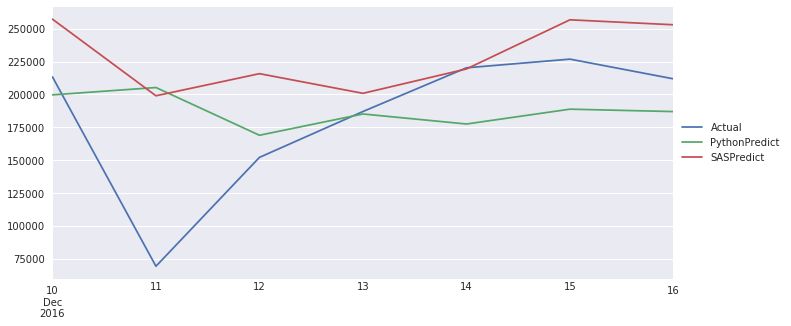

In [412]:
# -----------------------------------------------------------------------------------
# Daily Actual vs Forecast
# -----------------------------------------------------------------------------------
f = plt.figure(figsize=(15,5))
f.subplots_adjust(right=0.7)

#plot = Daily_forecast.plot(ax=f.gca())
plot = Daily_forecast[['Actual','PythonPredict','SASPredict']].plot(ax=f.gca())
plot.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig = plot.get_figure()
fig.savefig(workingDir + 'output/' + user + '/ATM_' + atmId + '_' + str(predStartDate.strftime('%Y-%m-%d')) + '_' + str(predEndDate.strftime('%Y-%m-%d')) + '_daily.jpeg')

In [413]:
# Claculate Mape
Daily_forecast['PyMape'] = Daily_forecast.apply(lambda df: custFun.calcMape(df.Actual, df.PythonPredict), axis=1)
Daily_forecast['SASMape'] = Daily_forecast.apply(lambda df: custFun.calcMape(df.Actual, df.SASPredict), axis=1)

Daily_forecast

,Actual,PythonPredict,SASPredict,SASSystemPredict,PyMape,SASMape
2016-12-10,213320,199687.0,257200.826644,217786.226719,6.39,20.57
2016-12-11,69480,205255.0,198984.370203,195433.853021,195.42,186.39
2016-12-12,152190,168995.0,215784.648152,194790.142604,11.04,41.79
2016-12-13,187030,185155.0,200840.021248,195434.478847,1.00,7.38
2016-12-14,220230,177545.0,219365.198860,205601.856749,19.38,0.39
2016-12-15,226830,188813.0,256699.804359,199640.211313,16.76,13.17
2016-12-16,211850,186980.0,252932.403414,215552.747901,11.74,19.39


In [414]:
custFun.evaluate_metric(Daily_forecast.Actual, Daily_forecast.PythonPredict)
custFun.evaluate_metric(Daily_forecast.Actual, Daily_forecast.SASPredict)

The Mean abs % Error of our forecasts is 37.39
The Mean abs % Error of our forecasts is 41.298


In [415]:
output = pd.DataFrame()

for index, row in forecast.iterrows():
    hourly_periods = 24
    dtRange = pd.date_range(index, periods=hourly_periods, freq='H')
    # get forecast value for date
    factor = forecast[index:index].y_hat_adj.values
    
    if (row['ph'] == 'Y'):
        # for fixed date holidays - e.g. New year, christmas etc.
        tempDf = dfProfile.loc[(dfProfile['type'] == row['type'])].index.strftime('%Y-%m-%d')
    elif (row['preholiday'] == 'Y'):
        tempDf = dfProfile.loc[(dfProfile['preholiday'] == row['preholiday']) & (dfProfile['weekday'] == row['weekday']) & (dfProfile['holidayoffset'] == row['holidayoffset'])].index.strftime('%Y-%m-%d')
        # if no observation are found for criteria
        if (len(tempDf) <= 1):
                tempDf = dfProfile.loc[(dfProfile['preholiday'] == row['preholiday']) & (dfProfile['holidayoffset'] == row['holidayoffset'])].index.strftime('%Y-%m-%d')
    elif (row['postholiday'] == 'Y'):
        tempDf = dfProfile.loc[(dfProfile['postholiday'] == row['postholiday']) & (dfProfile['weekday'] == row['weekday']) & (dfProfile['holidayoffset'] == row['holidayoffset'])].index.strftime('%Y-%m-%d')
        # if no observation are found for criteria
        if (len(tempDf) <= 1):
            tempDf = dfProfile.loc[(dfProfile['postholiday'] == row['postholiday']) & (dfProfile['holidayoffset'] == row['holidayoffset'])].index.strftime('%Y-%m-%d')
    else:
        tempDf = dfProfile.loc[(dfProfile['ph'] == row['ph']) & (dfProfile['holidayevecode'] == row['holidayevecode']) & (dfProfile['day'] == row['day']) & (dfProfile['weekday'] == row['weekday'])].index.strftime('%Y-%m-%d')
        
    # check if we have observations or not?
    if ((len(tempDf) > 1) or  (row['type'] in ['CNY','NYD','XMS'])) :
        y_hat_hr =  pd.DataFrame(custFun.getHourlyDist(tempDf, df_hr))
    else:
        tempDf = dfProfile.loc[(dfProfile['month'] == row['month']) & (dfProfile['weekday'] == row['weekday'])].index.strftime('%Y-%m-%d')
        y_hat_hr = pd.DataFrame(custFun.getHourlyDist(tempDf, df_hr))
        
    y_hat_hr.index = dtRange
    y_hat_hr.columns = ['amt']

    #Round to nearest unit value
    y_hat_hr = round(y_hat_hr*factor,2)
    output = output.append(y_hat_hr)

output = np.ceil(output)

In [416]:
# set negative forecast to $1
output['amt'] = output.apply(lambda df: custFun.adjustNegativeForecast(df.amt), axis=1) 

In [417]:
start = pd.to_datetime(predStartDate).strftime("%Y-%m-%d 00:00:00")
end = pd.to_datetime(predEndDate).strftime("%Y-%m-%d 23:00:00")

actuals = df_hr[start:end]

In [418]:
Hourly_Forecast = pd.merge(actuals, output, left_index=True, right_index=True, how='left')
Hourly_Forecast = pd.merge(Hourly_Forecast, dfSAS_hr[['predict','predict_system']], left_index=True, right_index=True, how='left')

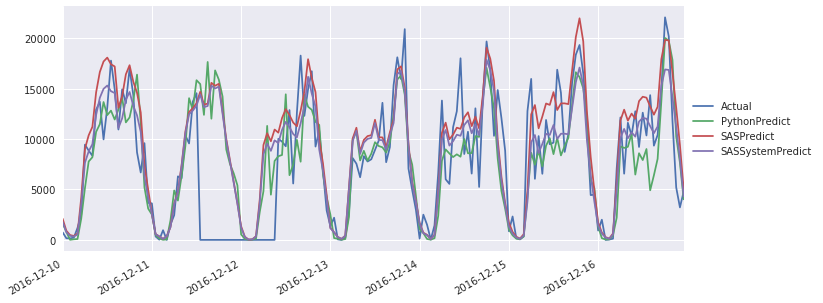

In [419]:
Hourly_Forecast.columns = ['Actual','PythonPredict','SASPredict','SASSystemPredict']

f = plt.figure(figsize=(15,5))
f.subplots_adjust(right=0.7)
plot = Hourly_Forecast.plot(ax=f.gca())
plot.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig = plot.get_figure()
fig.savefig(workingDir + 'output/' + user + '/ATM_' + atmId + '_' + str(predStartDate.strftime('%Y-%m-%d')) + '_' + str(predEndDate.strftime('%Y-%m-%d')) + '_hourly.jpeg')

In [420]:
Hourly_Forecast['PyMape'] = Hourly_Forecast.apply(lambda df: custFun.calcMape(df.Actual, df.PythonPredict), axis=1)
Hourly_Forecast['SASMape'] = Hourly_Forecast.apply(lambda df: custFun.calcMape(df.Actual, df.SASPredict), axis=1)

Hourly_Forecast.sort_index().head()

,Actual,PythonPredict,SASPredict,SASSystemPredict,PyMape,SASMape
2016-12-10 00:00:00,750,1635.0,2095.952499,1774.759406,118,179.46
2016-12-10 01:00:00,160,793.0,904.005072,765.471309,395.62,465
2016-12-10 02:00:00,150,8.0,475.886127,402.959218,94.67,217.26
2016-12-10 03:00:00,220,61.0,392.405164,332.271250,72.27,78.37
2016-12-10 04:00:00,1190,86.0,628.116116,531.860806,92.77,47.22


In [421]:
Daily_forecast.insert(0, 'runDate', trainEndDate)
Daily_forecast.insert(0, 'machineID', atmId)

Hourly_Forecast.insert(0, 'runDate', trainEndDate)
Hourly_Forecast.insert(0, 'machineID', atmId)

In [422]:
Daily_forecast.sort_index().to_csv(workingDir + "output/" + user + "/ATM_" + atmId + '_' + str(predStartDate.strftime('%Y-%m-%d')) + '_' + str(predEndDate.strftime('%Y-%m-%d')) + "_daily.csv")
Hourly_Forecast.sort_index().to_csv(workingDir + "output/" + user + "/ATM_" + atmId + '_' + str(predStartDate.strftime('%Y-%m-%d')) + '_' + str(predEndDate.strftime('%Y-%m-%d')) + "_hourly.csv")

In [423]:
Daily_forecast

,machineID,runDate,Actual,PythonPredict,SASPredict,SASSystemPredict,PyMape,SASMape
2016-12-10,5463,2016-12-09,213320,199687.0,257200.826644,217786.226719,6.39,20.57
2016-12-11,5463,2016-12-09,69480,205255.0,198984.370203,195433.853021,195.42,186.39
2016-12-12,5463,2016-12-09,152190,168995.0,215784.648152,194790.142604,11.04,41.79
2016-12-13,5463,2016-12-09,187030,185155.0,200840.021248,195434.478847,1.00,7.38
2016-12-14,5463,2016-12-09,220230,177545.0,219365.198860,205601.856749,19.38,0.39
2016-12-15,5463,2016-12-09,226830,188813.0,256699.804359,199640.211313,16.76,13.17
2016-12-16,5463,2016-12-09,211850,186980.0,252932.403414,215552.747901,11.74,19.39
